# Tutorial 01 - Loading and Analyzing Exported Pupil Data
In this tutorial we will look at how to load pupil data that was exported from Pupil Player into Python in order to analyze it further. 
We will follow these steps:
1. Load the data using `Pandas`.
1. Visualize pupil diameter and pupil location as a function of time.
1. Build a simple dispersion based fixation detector.

Raw Recording Data: To execute this notebook, download the [sample recording](https://drive.google.com/file/d/1vzjZkjoi8kESw8lBnsa_k_8hXPf3fMMC/view?usp=sharing). Unzip and move it into the `recordings` directory for this repository.

Export Data: Use [Pupil Player](https://github.com/pupil-labs/pupil/releases/latest) to playback the sample recording. The sample recording contains exported data that you can use in this notebook. You can [export additional data](https://docs.pupil-labs.com/core/software/pupil-player/) using Pupil Player if desired.


## 1 - Loading Exported Data

Let's start off by inspecting the overall file structure we have in our sample recording.

In [1]:
import os

recording_location = './recordings/sample_recording_v2'

def print_file_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print(f'{subindent}{f}')
print_file_structure(recording_location)

The original recording data, made with Pupil Capture, is located at the top level of the recording folder.

Exports from Pupil Player will be saved in a subfolder called `exports`. 

Every time we trigger an export in Pupil Player, a new folder will be created in `exports` containing the respective data. 

You might want to use multiple exports e.g. to export multiple sub-sections of your entire recording. 

In our sample data, there is only one export inside the folder `000`.

### Available Files
Raw data exports will contain the following files:

- `export_info.csv` - Meta information on the export containing e.g. the export date or the data format version.
- `pupil_positions.csv` - A list of all pupil datums. See below for more information.
- `gaze_positions.csv` - A list of all gaze datums. See below for more information.
- `pupil_gaze_positions_info.txt` - Contains documentation on the contents of `pupil_positions.csv` and `gaze_positions.csv`

Some Pupil Player plugins might add additional files. 
Check out the [Player export](https://docs.pupil-labs.com/core/software/pupil-player/#export) documentation for more details.

In this tutorial we are interested in data related to the pupil, which is contained in `pupil_positions.csv`. 

We use `Pandas` to load the CSV-file into a `Pandas` data frame (if you are unfamilar with `Pandas`, think of it as being similar to a Python dictionary).

In [2]:
import pandas as pd
exported_pupil_csv = os.path.join(recording_location, 'exports', '000', 'pupil_positions.csv')
pupil_pd_frame = pd.read_csv(exported_pupil_csv)

In [3]:
print("Columns present in pupil data:")
list(pupil_pd_frame.columns)

Columns present in pupil data:


['pupil_timestamp',
 'world_index',
 'eye_id',
 'confidence',
 'norm_pos_x',
 'norm_pos_y',
 'diameter',
 'method',
 'ellipse_center_x',
 'ellipse_center_y',
 'ellipse_axis_a',
 'ellipse_axis_b',
 'ellipse_angle',
 'diameter_3d',
 'model_confidence',
 'model_id',
 'sphere_center_x',
 'sphere_center_y',
 'sphere_center_z',
 'sphere_radius',
 'circle_3d_center_x',
 'circle_3d_center_y',
 'circle_3d_center_z',
 'circle_3d_normal_x',
 'circle_3d_normal_y',
 'circle_3d_normal_z',
 'circle_3d_radius',
 'theta',
 'phi',
 'projected_sphere_center_x',
 'projected_sphere_center_y',
 'projected_sphere_axis_a',
 'projected_sphere_axis_b',
 'projected_sphere_angle']

### Individual Datums
As we can see the data frame contains many columns, representing all the columns present in the CSV file.

Since Pupil v2.0 this output contains data from both the 2D and 3D pupil detector.

Most of the values are concerned with the state of the 3D eye model. 

We will now take a closer look at the subset of values most important for the next step, where we want to visualize pupil diameter and pupil location: 

- `pupil_timestamp` - The timestamp at which the sample was recorded.
- `eye_id` - Identifies the eye to which the sample belongs to. By default samples with `id = 0` belong to the right eye, while samples with `id = 1` belong to the left eye (from the wearer's POV!).
- `confidence` - Confidence in the pupil detection.
- `norm_pos` - The normalized position of the pupil in the eye image. (0,0) is bottom left corner of the eye image frame; (1,1) is the top right corner of the eye image frame.
- `diameter_3d` - The pupil diameter in mm.
- `method` - Which pupil detector was used to produce this datum.

For more information on the other available values please refer to the [pupil datum format](https://docs.pupil-labs.com/developer/core/overview/#pupil-datum-format) documentation.

Let's take a look at a few values from our sample data.

We need to filter the data for output from the 3D pupil detector, as we are interested in the `diameter_3d` column which is only present for 3D data.

*Note* : This recording was started without a properly stabilized 3D eye model. This causes a lot of noise in the beginning of the recording until the model is stabilized. Therefore, we will skip the first few seconds to work with stable data only.

In [4]:
from IPython.display import display

# filter for 3d data
detector_3d_data = pupil_pd_frame[pupil_pd_frame.method == '3d c++']

# skip first 5 seconds to allow for the 3D model to converge
start_time = detector_3d_data.pupil_timestamp.iloc[0] + 5
detector_3d_data = detector_3d_data[detector_3d_data.pupil_timestamp > start_time]

# split in left/right eye
eye0_df = detector_3d_data[detector_3d_data.eye_id == 0]
eye1_df = detector_3d_data[detector_3d_data.eye_id == 1]
pd.options.display.float_format = '{:.3f}'.format

print("eye0 (right eye) data:")
display(eye0_df[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

print("eye1 data (left eye) data:")
display(eye1_df[['pupil_timestamp', 'eye_id', 'confidence', 'norm_pos_x', 'norm_pos_y', 'diameter_3d']].head(10))

eye0 (right eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
1573,329358.724,0,0.996,0.607,0.428,6.571
1577,329358.744,0,0.996,0.605,0.430,6.614
1580,329358.759,0,0.530,0.602,0.430,6.600
1581,329358.764,0,0.591,0.599,0.430,6.586
1584,329358.774,0,0.996,0.605,0.431,6.616
1587,329358.784,0,0.594,0.606,0.431,6.532
1590,329358.794,0,0.660,0.607,0.431,6.529
1592,329358.799,0,0.621,0.607,0.431,6.521
1594,329358.804,0,0.562,0.612,0.427,6.582
1596,329358.809,0,0.588,0.612,0.427,6.510


eye1 data (left eye) data:


,pupil_timestamp,eye_id,confidence,norm_pos_x,norm_pos_y,diameter_3d
1572,329358.723,1,1.000,0.448,0.574,6.205
1574,329358.728,1,0.999,0.448,0.575,6.215
1575,329358.733,1,1.000,0.448,0.574,6.271
1576,329358.743,1,0.999,0.448,0.573,6.186
1578,329358.748,1,0.999,0.449,0.573,6.202
1579,329358.758,1,1.000,0.450,0.572,6.217
1582,329358.768,1,0.999,0.449,0.573,6.230
1583,329358.773,1,1.000,0.450,0.572,6.249
1585,329358.778,1,1.000,0.450,0.572,6.230
1586,329358.783,1,0.999,0.450,0.572,6.221


## 2 - Visualize Pupillometry Data

Now that we have the data available in Python we can immediately visualize it using the `Matplotlib` library.

In [5]:
import matplotlib.pyplot as plt

### Plot Pupil Diameter
The pupil diameter as a function of time:

Text(0.5, 1.0, 'Pupil Diameter')

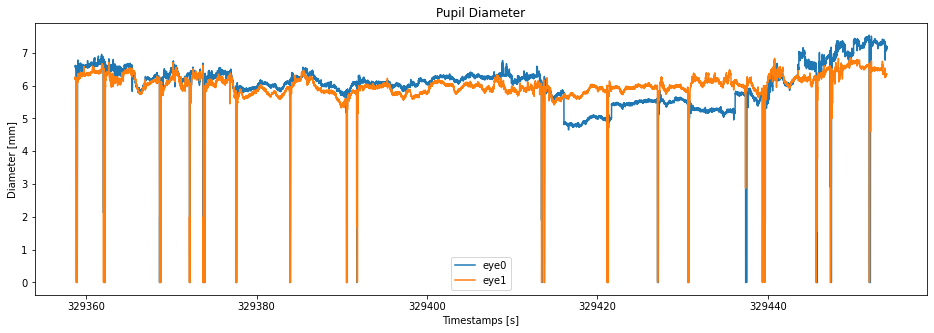

In [6]:
plt.figure(figsize=(16, 5))
plt.plot(eye0_df['pupil_timestamp'], eye0_df['diameter_3d'])
plt.plot(eye1_df['pupil_timestamp'], eye1_df['diameter_3d'])
plt.legend(['eye0', 'eye1'])
plt.xlabel('Timestamps [s]')
plt.ylabel('Diameter [mm]')
plt.title('Pupil Diameter')

As we can see there are spikes in the data. These spikes are due to false positive pupil detections typically occuring during blinks. We can filter out most of the erroneous values using the `confidence` measure. 

In [7]:
eye0_high_conf_df = eye0_df[eye0_df['confidence'] > 0.85]
eye1_high_conf_df = eye1_df[eye1_df['confidence'] > 0.85]

Text(0.5, 1.0, 'Pupil Diameter (only high confidence values)')

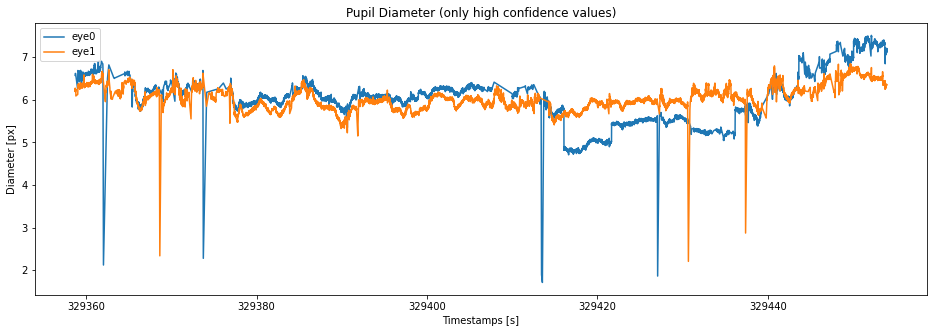

In [8]:
plt.figure(figsize=(16, 5))
plt.plot(eye0_high_conf_df['pupil_timestamp'], eye0_high_conf_df['diameter_3d'])
plt.plot(eye1_high_conf_df['pupil_timestamp'], eye1_high_conf_df['diameter_3d'])
plt.legend(['eye0', 'eye1'])
plt.xlabel('Timestamps [s]')
plt.ylabel('Diameter [px]')
plt.title('Pupil Diameter (only high confidence values)')

### Plot Pupil Positions
#### Pupil Positions Over Time
Next, we will visualize the pupil positions in the eye image over time. Low confidence points will not be visualized. 

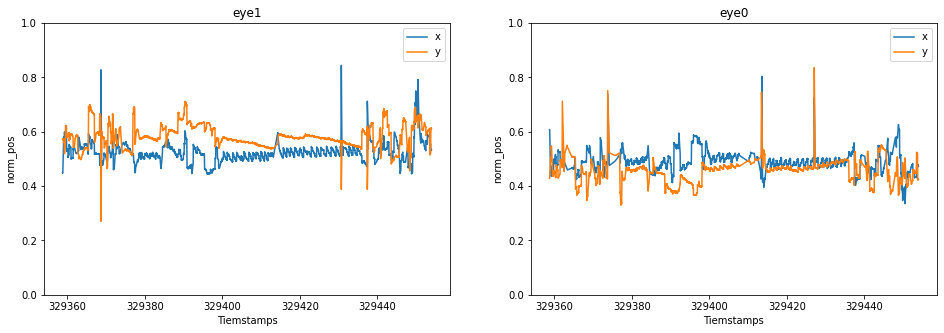

In [9]:
plt.figure(figsize=(16, 5))

# plot left eye
plt.subplot(1, 2, 1)
plt.plot(eye1_high_conf_df['pupil_timestamp'], eye1_high_conf_df['norm_pos_x'])
plt.plot(eye1_high_conf_df['pupil_timestamp'], eye1_high_conf_df['norm_pos_y'])
plt.xlabel('Tiemstamps')
plt.ylabel('norm_pos')
plt.ylim([0, 1])
plt.title('eye1')
plt.legend("xy")

# plot right eye
plt.subplot(1, 2, 2)
plt.plot(eye0_high_conf_df['pupil_timestamp'], eye0_high_conf_df['norm_pos_x'])
plt.plot(eye0_high_conf_df['pupil_timestamp'], eye0_high_conf_df['norm_pos_y'])
plt.xlabel('Tiemstamps')
plt.ylabel('norm_pos')
plt.ylim([0, 1])
plt.title('eye0')
plt.legend("xy")

#### Spatial Distribution
Alternatively, we will visualize the spatial distribution of pupil positions in the eye image in form of a scatter plot. Again we discard low confidence points. We will color code each point with it's timestamp, this way we can roughly see the trajectory each pupil had during the recording.

Text(0.5, 1.0, 'eye0')

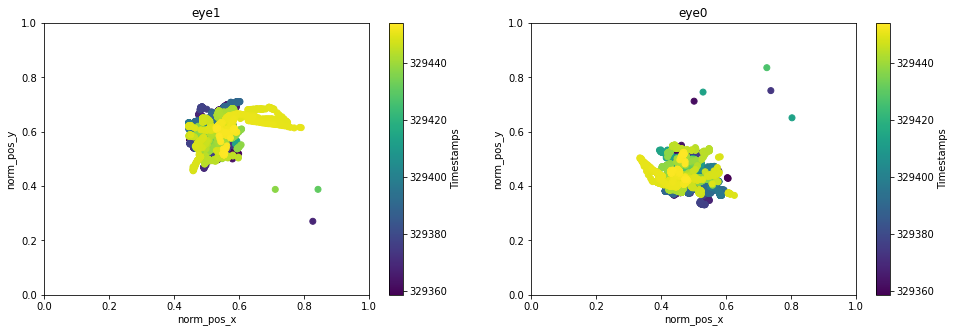

In [10]:
plt.figure(figsize=(16, 5))

# plot left eye
plt.subplot(1, 2, 1)
plt.scatter(eye1_high_conf_df['norm_pos_x'], eye1_high_conf_df['norm_pos_y'], c=eye1_high_conf_df['pupil_timestamp'])
plt.colorbar().ax.set_ylabel('Timestamps')
plt.xlabel('norm_pos_x')
plt.ylabel('norm_pos_y')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('eye1')

# plot right eye
plt.subplot(1, 2, 2)
plt.scatter(eye0_high_conf_df['norm_pos_x'], eye0_high_conf_df['norm_pos_y'], c=eye0_high_conf_df['pupil_timestamp'])
plt.colorbar().ax.set_ylabel('Timestamps')
plt.xlabel('norm_pos_x')
plt.ylabel('norm_pos_y')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('eye0')

## 3 - A Simple Fixation Detector
Next we will build a simple fixation detector. 
It will be a slightly simplified version of the [Offline Fixation Detector](https://github.com/pupil-labs/pupil/blob/244661b19c71d105ef2f6946b5b014c0682734f3/pupil_src/shared_modules/fixation_detector.py#L250) implemented in Pupil Player.

We will classify an eye movement as a fixation if the maximum dispersion of pupil positions within this movement is below a threshold value `max_dispersion`.

To measure movement we will consider the 3D eye model: For every pupil datum we are given the state of the model including the orientation of the eye ball in relation to the eye camera. 
A movement of the eye is visible in the model as a rotation of the eye ball.
This measure is handy because it is independent of the exact eye camera position and the physiology of the subject.

The orientation of the eye model is encoded in the normal vector of the 3D pupil circle, which is included in every pupil datum. 
Calculating pupil dispersion with a list of such vectors comes down to calculating the angles between them pairwise and taking the maximum. 

To be more robust against outliers we will return the average of the largest 20% of all distances instead of the absolute maximum.

In [11]:
import numpy as np
import scipy.spatial.distance

def vector_dispersion(vectors):
    distances = scipy.spatial.distance.pdist(vectors, metric='cosine')
    distances.sort()
    cut_off = np.max([distances.shape[0] // 5, 4])
    return np.arccos(1. - distances[-cut_off:].mean())

We will set the maximum dispersion allowed within a fixation to `max_dispersion = 3°`, i.e. the maximal pairwise difference in rotation of the eye ball between all samples of a fixation must be smaller than 3°.
For additional robustness we will set a minimum duration for a fixation of `min_duration = 0.3 sec`.

In [12]:
max_dispersion = np.deg2rad(3)
min_duration = 0.3

Since we have data for both the right and left eye, we will always simply pick the eye that provides more high confidence data samples. We will use the following function to calculate the dispersion of candidate sequence of pupil datums:

In [13]:
def gaze_dispersion(eye_data):
    eye0_data = [p for p in eye_data if p['eye_id'] == 0 and p['confidence'] > 0.95]
    eye1_data = [p for p in eye_data if p['eye_id'] == 1 and p['confidence'] > 0.95]
    base_data = eye1_data if len(eye1_data) > len(eye0_data) else eye0_data

    vectors = []
    for p in base_data:
        vectors.append((p['circle_3d_normal_x'], p['circle_3d_normal_y'], p['circle_3d_normal_z']))
    vectors = np.array(vectors, dtype=np.float32)

    if len(vectors) < 2:
        return float("inf")
    else:
        return vector_dispersion(vectors)

We will use a very simple algorithm to find all fixations in a sequence of pupil datums based on the above dispersion calculation. We will run a dynamic window over our sequence from start to finish. 
At each step we will check if the window contains a valid fixation. 
If yes, we extend the window to the right in case the fixation is longer than our window until we find the end of the fixation. 
If not, we move the window to the right.
If we find a fixation, we return the start and end timestamp of it.

In [14]:
from collections import deque

def detect_fixations(gaze_data):
    # Convert Pandas data frame to list of Python dictionaries
    gaze_data = gaze_data.T.to_dict().values()

    candidate = deque()
    future_data = deque(gaze_data)
    while future_data:
        # check if candidate contains enough data
        if len(candidate) < 2 or candidate[-1]['pupil_timestamp'] - candidate[0]['pupil_timestamp'] < min_duration:
            datum = future_data.popleft()
            candidate.append(datum)
            continue

        # Minimal duration reached, check for fixation
        dispersion = gaze_dispersion(candidate)
        if dispersion > max_dispersion:
            # not a fixation, move forward
            candidate.popleft()
            continue

        # Minimal fixation found. Try to extend!
        while future_data:
            datum = future_data[0]
            candidate.append(datum)

            dispersion = gaze_dispersion(candidate)
            if dispersion > max_dispersion:
                # end of fixation found
                candidate.pop()
                break
            else:
                # still a fixation, continue extending
                future_data.popleft()
                
        yield (candidate[0]['pupil_timestamp'], candidate[-1]['pupil_timestamp'])
        candidate.clear()

In [15]:
%time fixations = list(detect_fixations(detector_3d_data))

CPU times: user 9.47 s, sys: 64.9 ms, total: 9.54 s
Wall time: 9.54 s


Once we have extracted all fixations from the pupil data, we can visualize their occurrences across time using `Matplotlib`.
Note how we can distinctly see the 5 long calibration fixations!

Text(0.5, 1.0, 'Occurrences of Fixations')

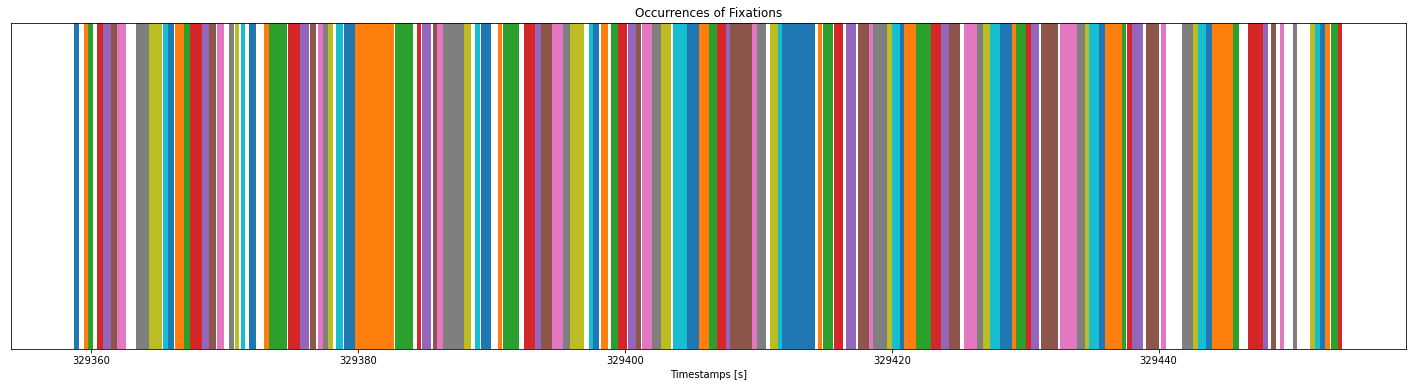

In [16]:
plt.rcParams['figure.figsize'] = (25, 6)
for fix in fixations:
    length = fix[1] - fix[0]
    plt.bar(fix[0], 1.0, length, align='edge')
plt.xlabel("Timestamps [s]")
plt.ylim((0,1))
plt.gca().get_yaxis().set_visible(False)
plt.title("Occurrences of Fixations")

## Conclusion
In this tutorial we have seen how to load data exported from Pupil Player into Python. 
The data is available in CSV-files, which can easily be imported using `Pandas`. 
Next, we visualized the pupil diameter as a function of time and the spatial distribution of pupil positions available in the sample recording.
After loading the data into Python this was immediately possible using `Matplotlib`.
Finally we built a simple fixation detector based on dispersion and visualized all fixations occurring in the sample recording.

If you have questions regarding the tutorial or any other Pupil Labs software, please refer to our [Discord](https://discord.gg/gKmmGqy) server or consider the [Docs](https://docs.pupil-labs.com/).
If you have any feedback for us concerning this tutorial we would also love to hear it over Discord!